# Proyecto proyecciones de energía y montos


# Pendientes

* Tratar tema de datos no estacionarios
* realizar proyecciones y datos con primeras diferencias transformarlos a datos normales

In [ ]:
import pandas as pd
import numpy as np
from datetime import date

import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler, LabelEncoder, scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#from unit_root_test import df_test, adf_test, pp_test, kpss_test, dfgls_test

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Obtención de Dataset

In [ ]:
path = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/EnergiaMontos_CE_17-24.csv'
path_pred_input = '/content/drive/MyDrive/Colab_Notebooks/Cenace/DataScience/DatasetsCENACE/ProyectoInversionCE/INPUT_ESTIMACIONES_CENTRALES_24-30.csv'

In [ ]:
df = pd.read_csv(path)

df_input = pd.read_csv(path_pred_input)

print(df.info())
print(df.shape)

print('Dimension datos de entrada para proyecciones')
print(df_input.info())
print(df_input.shape)


df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18655 entries, 0 to 18654
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        18655 non-null  object 
 1   ANIO         18655 non-null  int64  
 2   MES          18655 non-null  int64  
 3   CLV_CENTRAL  18655 non-null  object 
 4   TIPO_TEC     18655 non-null  object 
 5   ENERGIA      18655 non-null  float64
 6   MONTO_NETO   18655 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1020.3+ KB
None
(18655, 7)
Dimension datos de entrada para proyecciones
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18655 entries, 0 to 18654
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FECHA_LP         18655 non-null  object 
 1   FECHA_LP_STRING  18655 non-null  object 
 2   ANIO_LP          18655 non-null  int64  
 3   MES_LP           18655 non-null  int64  
 4 

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO
0,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08
1,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06
2,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05
3,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08
4,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04


In [ ]:
df['fecha'] = pd.to_datetime(df['FECHA'])

df = df.loc[df['fecha'] <= '2023-12-01']


print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18057 entries, 0 to 18056
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        18057 non-null  object        
 1   ANIO         18057 non-null  int64         
 2   MES          18057 non-null  int64         
 3   CLV_CENTRAL  18057 non-null  object        
 4   TIPO_TEC     18057 non-null  object        
 5   ENERGIA      18057 non-null  float64       
 6   MONTO_NETO   18057 non-null  float64       
 7   fecha        18057 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.2+ MB
None


,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha
0,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08,2017-01-01
1,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06,2017-01-01
2,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05,2017-01-01
3,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08,2017-01-01
4,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04,2017-01-01


In [ ]:
df.set_index(df['fecha'], inplace=True)
df.head()

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha
fecha,,,,,,,,
2017-01-01,2017-01-01,2017,1,CCM,CC,214765.105247,1.467179e+08,2017-01-01
2017-01-01,2017-01-01,2017,1,PER,EO,2766.589000,1.672234e+06,2017-01-01
2017-01-01,2017-01-01,2017,1,PFC,FV,498.640000,2.953745e+05,2017-01-01
2017-01-01,2017-01-01,2017,1,PJZ,CC,282142.861000,1.945347e+08,2017-01-01
2017-01-01,2017-01-01,2017,1,01IUB,FV,84.390000,9.109799e+04,2017-01-01


## Creación de Dataframe de una UCE para estudio

In [ ]:
central = '01VAE'
df_subset = df.loc[df['CLV_CENTRAL'] == central]
df_subset.head()

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha
fecha,,,,,,,,
2017-01-01,2017-01-01,2017,1,01VAE,CC,175206.702,1.731094e+08,2017-01-01
2017-02-01,2017-02-01,2017,2,01VAE,CC,285625.909,2.638124e+08,2017-02-01
2017-03-01,2017-03-01,2017,3,01VAE,CC,165514.932,1.743361e+08,2017-03-01
2017-04-01,2017-04-01,2017,4,01VAE,CC,132136.504,1.615527e+08,2017-04-01
2017-05-01,2017-05-01,2017,5,01VAE,CC,107854.582,1.573056e+08,2017-05-01


# Analisis Exploratorio de Datos

In [ ]:
energia = df['ENERGIA'].values
monto = df['MONTO_NETO'].values
tiempo = df['fecha'].values

Text(0.5, 0, 'Periodo')

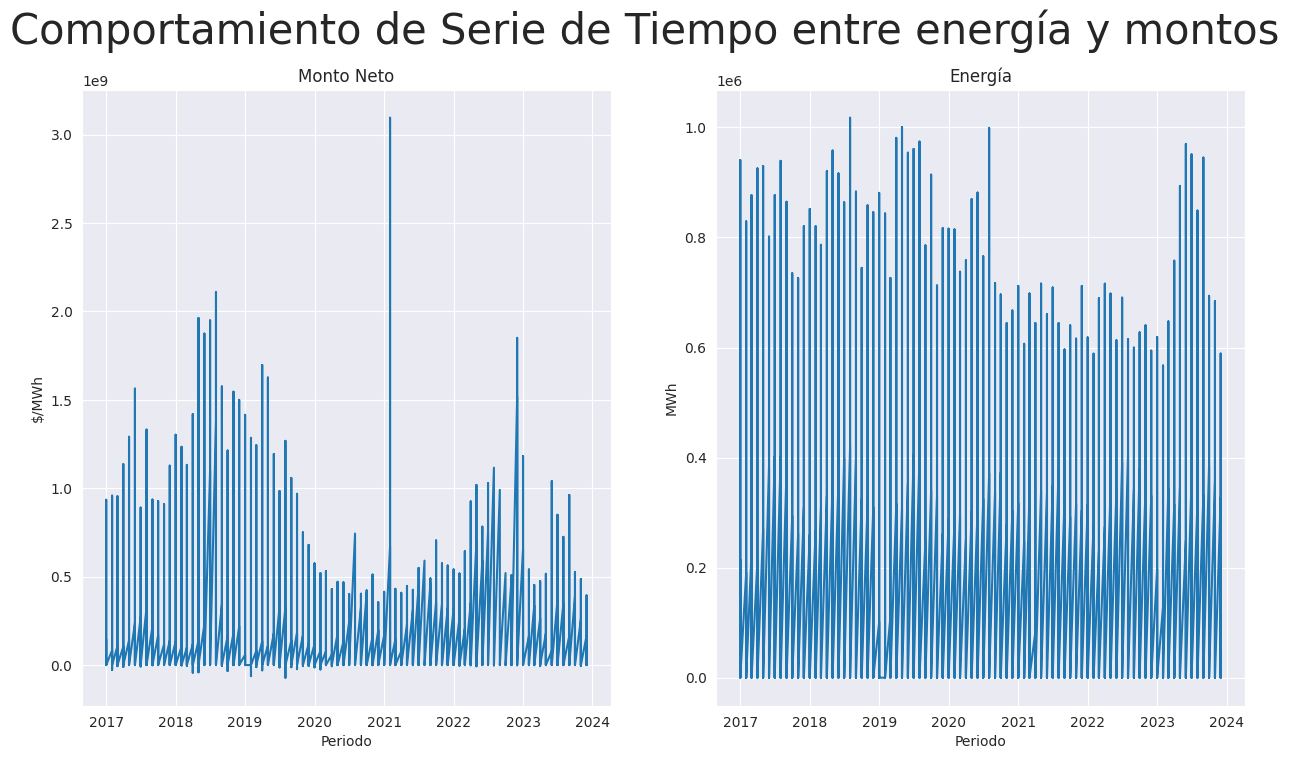

In [ ]:
sns.set_style("darkgrid")

# fig, axs = plt.subplots(2,2, figsize=(25, 15))
# fig.suptitle('Comportamiento de Serie de Tiempo entre energía y montos', fontsize=30)

# axs[0,0].plot(tiempo, monto)
# axs[0,0].set_title('Monto Neto')
# axs[0,0].set_ylabel('$/MWh')
# axs[0,0].set_xlabel('Periodo')

# axs[1,0].plot(tiempo, energia)
# axs[1,0].set_title('Energía')
# axs[1,0].set_ylabel('MWh')
# axs[1,0].set_xlabel('Periodo')


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
fig.suptitle('Comportamiento de Serie de Tiempo entre energía y montos', fontsize=30)

ax1.plot(tiempo, monto)
ax1.set_title('Monto Neto')
ax1.set_ylabel('$/MWh')
ax1.set_xlabel('Periodo')

ax2.plot(tiempo, energia)
ax2.set_title('Energía')
ax2.set_ylabel('MWh')
ax2.set_xlabel('Periodo')

In [ ]:
px.scatter(x= energia, y= monto, title='Correlación entre Montos y Energia' )

## Dataframe de estudio con una UCE

In [ ]:
energia_subset = df_subset['ENERGIA'].values
monto_subset = df_subset['MONTO_NETO'].values
tiempo_subset = df_subset['fecha'].values

Text(0.5, 0, 'Periodo')

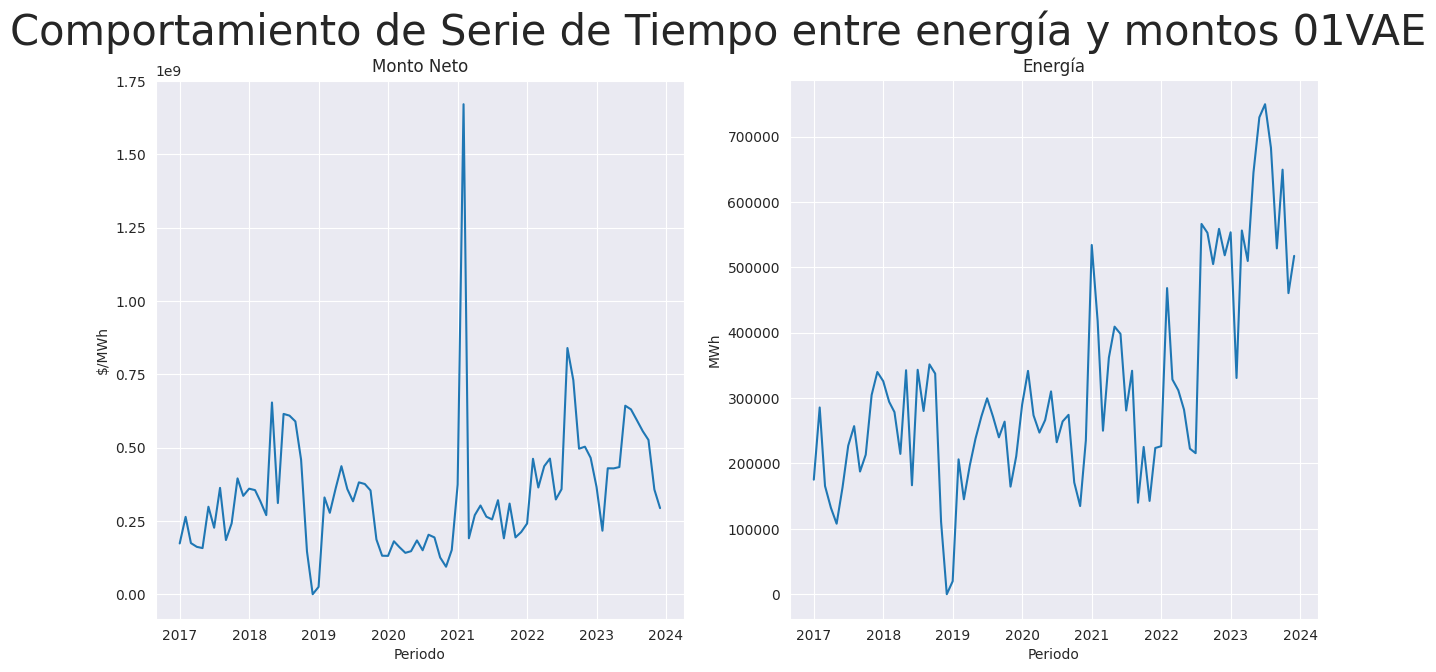

In [ ]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
fig.suptitle(f'Comportamiento de Serie de Tiempo entre energía y montos {central}', fontsize=30)

ax1.plot(tiempo_subset, monto_subset)
ax1.set_title('Monto Neto')
ax1.set_ylabel('$/MWh')
ax1.set_xlabel('Periodo')

ax2.plot(tiempo_subset, energia_subset)
ax2.set_title('Energía')
ax2.set_ylabel('MWh')
ax2.set_xlabel('Periodo')

## Detección Outliers


In [ ]:
z_score_monto =  (df_subset['MONTO_NETO'] - df_subset['MONTO_NETO'].mean()) / df_subset['MONTO_NETO'].std()

print(z_score_monto)


df_subset['z_score_monto'] = z_score_monto
df_subset['dummy_monto'] = 0

fecha
2017-01-01   -0.768825
2017-02-01   -0.356945
2017-03-01   -0.763255
2017-04-01   -0.821304
2017-05-01   -0.840590
                ...   
2023-08-01    1.140028
2023-09-01    0.969785
2023-10-01    0.833944
2023-11-01    0.066729
2023-12-01   -0.221855
Name: MONTO_NETO, Length: 84, dtype: float64


<ipython-input-389-3cb1a9922e8d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-389-3cb1a9922e8d>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Actualiza columna con base en condicion
df_subset.loc[abs(df_subset['z_score_monto']) > 3, 'dummy_monto'] = 1

df_subset.head()



,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha,z_score_monto,dummy_monto
fecha,,,,,,,,,,
2017-01-01,2017-01-01,2017,1,01VAE,CC,175206.702,1.731094e+08,2017-01-01,-0.768825,0
2017-02-01,2017-02-01,2017,2,01VAE,CC,285625.909,2.638124e+08,2017-02-01,-0.356945,0
2017-03-01,2017-03-01,2017,3,01VAE,CC,165514.932,1.743361e+08,2017-03-01,-0.763255,0
2017-04-01,2017-04-01,2017,4,01VAE,CC,132136.504,1.615527e+08,2017-04-01,-0.821304,0
2017-05-01,2017-05-01,2017,5,01VAE,CC,107854.582,1.573056e+08,2017-05-01,-0.840590,0


In [ ]:
df_subset.loc[abs(df_subset['z_score_monto']) > 3]

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha,z_score_monto,dummy_monto
fecha,,,,,,,,,,
2021-02-01,2021-02-01,2021,2,01VAE,CC,417847.705165,1.670986e+09,2021-02-01,6.033004,1


Text(0.5, 0, 'Periodo')

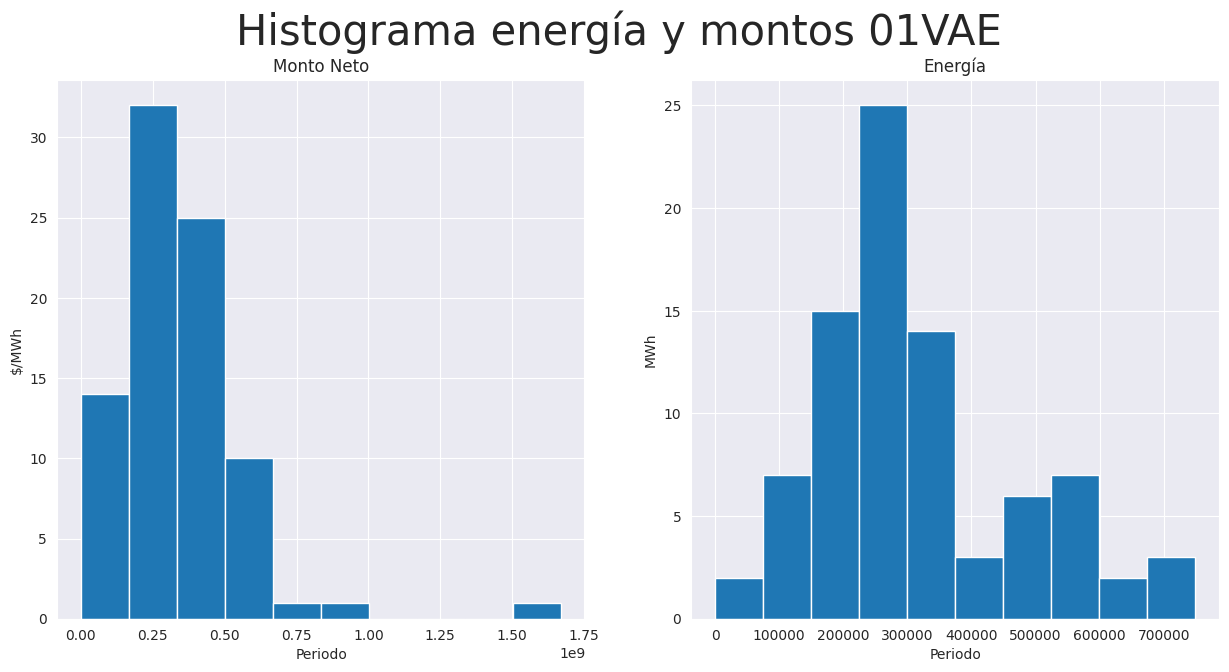

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))
fig.suptitle(f'Histograma energía y montos {central}', fontsize=30)

ax1.hist(monto_subset)
ax1.set_title('Monto Neto')
ax1.set_ylabel('$/MWh')
ax1.set_xlabel('Periodo')

ax2.hist(energia_subset)
ax2.set_title('Energía')
ax2.set_ylabel('MWh')
ax2.set_xlabel('Periodo')

In [ ]:
px.scatter(x= energia_subset, y= monto_subset, title='Correlación entre Montos y Energia' )

## Descomposición de Serie de Tiempo

In [ ]:
decompose_monto = seasonal_decompose(df_subset['MONTO_NETO'], model='additive')

# plt.plot(decompose.trend, label='Additive Trend')
# plt.legend()

Text(0.5, 0, 'Periodo')

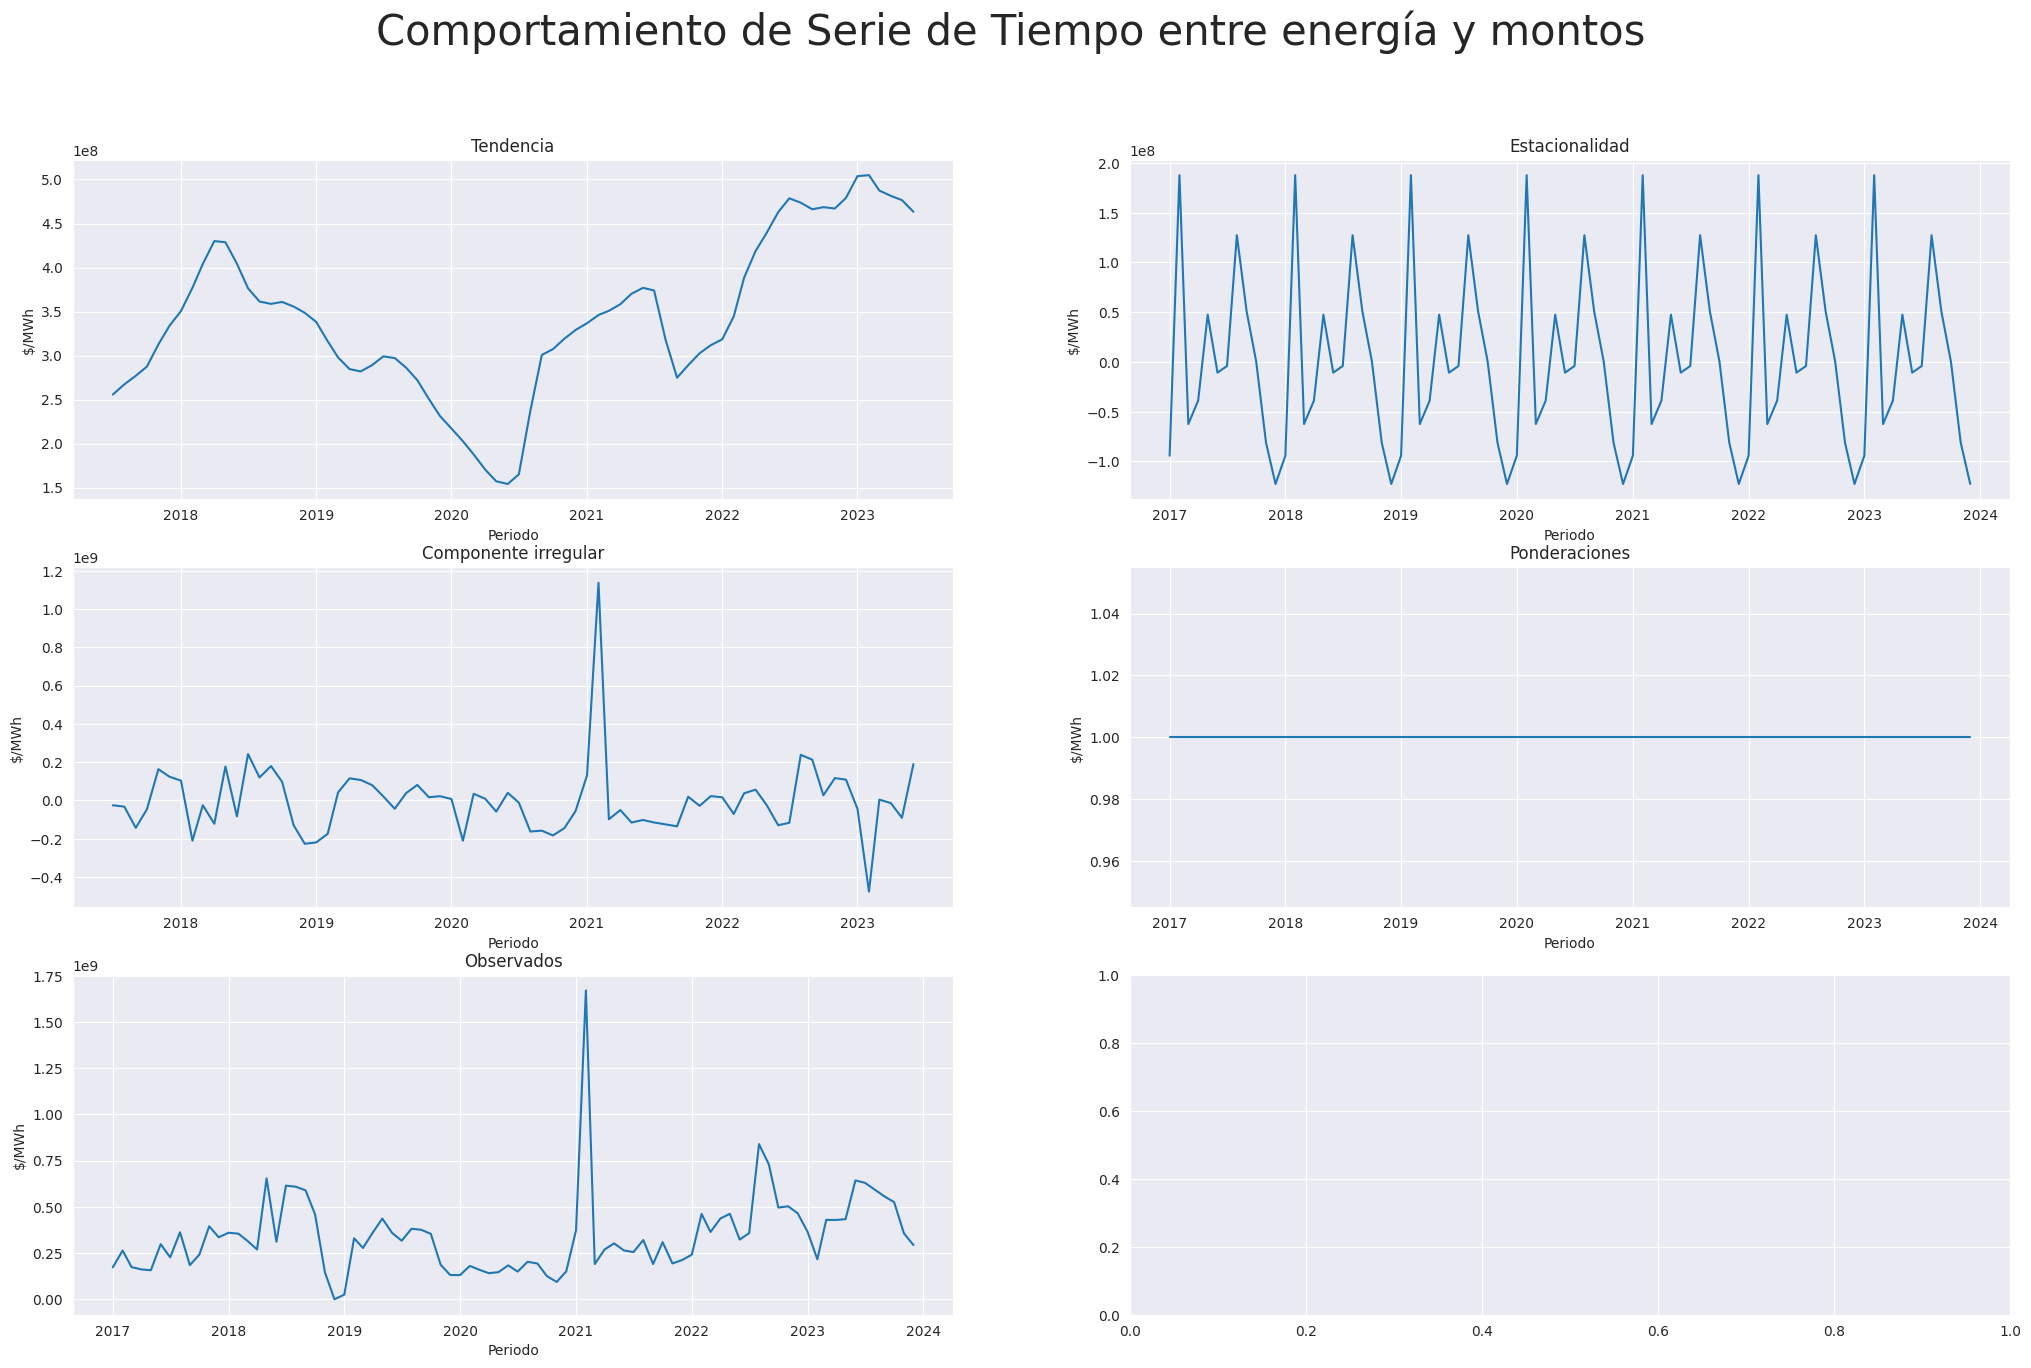

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(25, 15))
fig.suptitle('Comportamiento de Serie de Tiempo entre energía y montos', fontsize=30)

axs[0,0].plot(decompose_monto.trend, label= 'Tendencia')
axs[0,0].set_title('Tendencia')
axs[0,0].set_ylabel('$/MWh')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(decompose_monto.seasonal, label='Estacionalidad')
axs[0,1].set_title('Estacionalidad')
axs[0,1].set_ylabel('$/MWh')
axs[0,1].set_xlabel('Periodo')


axs[1,0].plot(decompose_monto.resid, label='Irregular')
axs[1,0].set_title('Componente irregular')
axs[1,0].set_ylabel('$/MWh')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(decompose_monto.weights, label='Ponderaciones')
axs[1,1].set_title('Ponderaciones')
axs[1,1].set_ylabel('$/MWh')
axs[1,1].set_xlabel('Periodo')

axs[2,0].plot(decompose_monto.observed, label='Observados')
axs[2,0].set_title('Observados')
axs[2,0].set_ylabel('$/MWh')
axs[2,0].set_xlabel('Periodo')

In [ ]:
df_subset['trend'] = decompose_monto.trend
df_subset['seasonal'] = decompose_monto.seasonal
df_subset['resid'] = decompose_monto.resid


<ipython-input-396-50676499451e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-396-50676499451e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-396-50676499451e>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print(type(decompose_monto.seasonal))

decompose_monto.seasonal

<class 'pandas.core.series.Series'>


fecha
2017-01-01   -9.419329e+07
2017-02-01    1.877804e+08
2017-03-01   -6.236069e+07
2017-04-01   -3.884230e+07
2017-05-01    4.750310e+07
                  ...     
2023-08-01    1.274262e+08
2023-09-01    5.065212e+07
2023-10-01    4.959818e+05
2023-11-01   -8.112571e+07
2023-12-01   -1.226135e+08
Name: seasonal, Length: 84, dtype: float64

In [ ]:
count_null = df_subset.isnull().sum()
total = df_subset.isnull().count()
percent = count_null / total


df_null = pd.concat([count_null, percent], axis= 1, keys= ['count_null', 'percent']).T

df_null

,FECHA,ANIO,MES,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,fecha,z_score_monto,dummy_monto,trend,seasonal,resid
count_null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.000000,0.0,12.000000
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.142857


In [ ]:
#df_subset.fillna(df_subset['MONTO_NETO'].median(), inplace = True)
df_subset['trend'].fillna(df_subset['trend'].median(), inplace = True)
df_subset['resid'].fillna(df_subset['resid'].median(), inplace = True)


<ipython-input-399-e0488945338c>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-399-e0488945338c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Estimación

## Dataframe de estudio

In [ ]:
columns_predict = ['trend', 'seasonal', 'resid', 'dummy_monto']

X = df_subset[columns_predict].sort_index(ascending=True)
y = df_subset['MONTO_NETO'].sort_index(ascending=True)


# X = pd.DataFrame(scale(X))
# y = pd.DataFrame(scale(y))
# X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


X_train = X_train.sort_index(ascending=True)
X_test = X_test.sort_index(ascending=True)
y_train = y_train.sort_index(ascending=True)
y_test = y_test.sort_index(ascending=True)

In [ ]:
print(y)
print('.--------------------------------')
print(y_test)

fecha
2017-01-01    1.731094e+08
2017-02-01    2.638124e+08
2017-03-01    1.743361e+08
2017-04-01    1.615527e+08
2017-05-01    1.573056e+08
                  ...     
2023-08-01    5.934707e+08
2023-09-01    5.559803e+08
2023-10-01    5.260660e+08
2023-11-01    3.571123e+08
2023-12-01    2.935613e+08
Name: MONTO_NETO, Length: 84, dtype: float64
.--------------------------------
fecha
2017-01-01    1.731094e+08
2017-02-01    2.638124e+08
2017-07-01    2.267121e+08
2017-09-01    1.847824e+08
2017-10-01    2.417295e+08
2019-01-01    2.499717e+07
2019-03-01    2.776670e+08
2019-06-01    3.586956e+08
2019-07-01    3.168407e+08
2019-09-01    3.758595e+08
2019-11-01    1.867077e+08
2020-02-01    1.805096e+08
2020-04-01    1.411266e+08
2020-06-01    1.834700e+08
2020-07-01    1.498413e+08
2020-08-01    2.028803e+08
2020-11-01    9.372867e+07
2020-12-01    1.510163e+08
2021-03-01    1.907382e+08
2021-11-01    1.937745e+08
2023-01-01    3.658929e+08
2023-02-01    2.166207e+08
2023-03-01    4.29

In [ ]:
# Build - fit model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.params)
print(results.summary())

const          1.762476e+07
trend          9.745876e-01
seasonal       1.041847e+00
resid          9.999712e-01
dummy_monto   -1.665570e+07
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             MONTO_NETO   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           2.68e-28
Time:                        22:45:45   Log-Likelihood:                -1128.1
No. Observations:                  58   AIC:                             2266.
Df Residuals:                      53   BIC:                             2276.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|

In [ ]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test).sort_index(ascending=True)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Text(0, 0.5, '$')

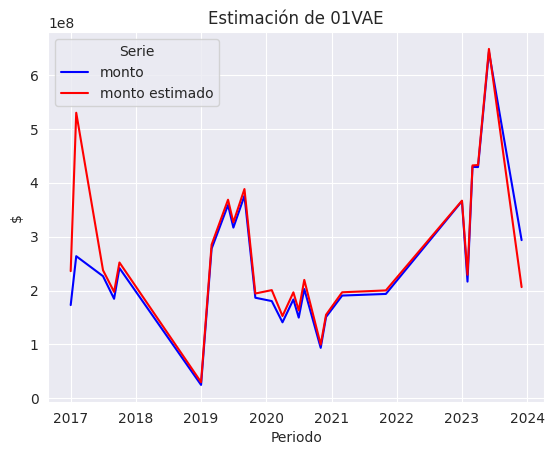

In [ ]:
print(type(y_pred))
print(type(y_test))
print(type(y))


#plt.plot(y, label='monto', color='green')
plt.plot(y_test, label='monto', color='blue')
plt.plot(y_pred, label= 'monto estimado', color='red')

#add legend
plt.legend(title='Serie')
plt.title(f'Estimación de {central}')
plt.xlabel(f'Periodo')
plt.ylabel(f'$')

# Proyección a largo plazo

## Creación de dataframe para proyecciones (out of sample)
* Se utiliza información histórica de la serie

In [ ]:
## Creación de dataframe a largo plazo

# present = '2022-05-05'
# print('date : ' + present)
# new_date = pd.to_datetime(present) + pd.DateOffset(months=5)
# print('new date is : '+str(new_date))

# add_column = ['fecha']
# #columns_new = ['trend', 'seasonal', 'resid', 'dummy_monto']

# columns_new = columns_predict + add_column


# df_lp = df_subset[columns_new]
# df_lp.drop(columns=['fecha'], inplace= True)
# df_lp = df_lp.reset_index()



# df_lp['outSampleDate'] = pd.to_datetime(df_lp['fecha'] + pd.DateOffset(months = 84))
# df_lp['dummy_monto'] = 0

# print(df_lp.info())
# df_lp.set_index(df_lp['outSampleDate'], inplace=True)

# df_lp

df_input['fecha_lp'] = pd.to_datetime(df_input['FECHA_LP_STRING'])

df_input.set_index(df_input['fecha_lp'], inplace=True)
#df_input = df_input.set_index(['CLV_CENTRAL', 'fecha_lp'])

print(df_input.info())
df_input.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18655 entries, 2024-01-01 to 2031-02-01
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FECHA_LP         18655 non-null  object        
 1   FECHA_LP_STRING  18655 non-null  object        
 2   ANIO_LP          18655 non-null  int64         
 3   MES_LP           18655 non-null  int64         
 4   CLV_CENTRAL      18655 non-null  object        
 5   TIPO_TEC         18655 non-null  object        
 6   ENERGIA          18655 non-null  float64       
 7   MONTO_NETO       18655 non-null  float64       
 8   Z_SCORE_ENERGIA  18655 non-null  float64       
 9   Z_SCORE_MONTO    18655 non-null  float64       
 10  ENERGIA_EB       18655 non-null  float64       
 11  MONTO_EB         18655 non-null  float64       
 12  ENERGIA_EM       18655 non-null  float64       
 13  MONTO_EM         18655 non-null  float64       
 14  ENERGIA_EA       1865

,FECHA_LP,FECHA_LP_STRING,ANIO_LP,MES_LP,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,Z_SCORE_ENERGIA,Z_SCORE_MONTO,ENERGIA_EB,MONTO_EB,ENERGIA_EM,MONTO_EM,ENERGIA_EA,MONTO_EA,fecha_lp
fecha_lp,,,,,,,,,,,,,,,,,
2024-01-01,01/01/24,2024-01-01,2024,1,CCM,CC,214765.105247,1.467179e+08,0.5114,0.0812,219275.172457,1.497989e+08,220134.232878,1.503858e+08,220993.293299,1.509727e+08,2024-01-01
2024-02-01,01/02/24,2024-02-01,2024,2,CCM,CC,190920.959000,8.356557e+07,0.3816,-0.2114,194930.299139,8.532045e+07,195693.982975,8.565471e+07,196457.666811,8.598898e+07,2024-02-01
2024-03-01,01/03/24,2024-03-01,2024,3,CCM,CC,228021.836000,1.070203e+08,0.5835,-0.1027,232810.294556,1.092677e+08,233722.381900,1.096958e+08,234634.469244,1.101239e+08,2024-03-01
2024-04-01,01/04/24,2024-04-01,2024,4,CCM,CC,211149.651000,1.043943e+08,0.4917,-0.1149,215583.793671,1.065866e+08,216428.392275,1.070042e+08,217272.990879,1.074218e+08,2024-04-01
2024-05-01,01/05/24,2024-05-01,2024,5,CCM,CC,270517.863000,1.397430e+08,0.8147,0.0489,276198.738123,1.426776e+08,277280.809575,1.432365e+08,278362.881027,1.437955e+08,2024-05-01


In [ ]:
df_input = df_input.loc[df_input['CLV_CENTRAL'] == central]


df_input.tail()

,FECHA_LP,FECHA_LP_STRING,ANIO_LP,MES_LP,CLV_CENTRAL,TIPO_TEC,ENERGIA,MONTO_NETO,Z_SCORE_ENERGIA,Z_SCORE_MONTO,ENERGIA_EB,MONTO_EB,ENERGIA_EM,MONTO_EM,ENERGIA_EA,MONTO_EA,fecha_lp
fecha_lp,,,,,,,,,,,,,,,,,
2030-10-01,01/10/30,2030-10-01,2030,10,01VAE,CC,69097.355900,4.761663e+07,4.1604,4.3924,70548.400374,4.861658e+07,70824.789797,4.880704e+07,71101.179221,4.899751e+07,2030-10-01
2030-11-01,01/11/30,2030-11-01,2030,11,01VAE,CC,460513.493346,3.571123e+08,2.8066,2.8413,470184.276706,3.646116e+08,472026.330680,3.660401e+08,473868.384653,3.674685e+08,2030-11-01
2030-12-01,01/12/30,2030-12-01,2030,12,01VAE,CC,69097.355900,2.935613e+08,3.2150,2.2579,70548.400374,2.997261e+08,70824.789797,3.009004e+08,71101.179221,3.020746e+08,2030-12-01
2031-01-01,01/01/31,2031-01-01,2031,1,01VAE,CC,58026.667900,2.812755e+07,3.9585,5.6752,59245.227926,2.871823e+07,59477.334597,2.883074e+07,59709.441269,2.894325e+07,2031-01-01
2031-02-01,01/02/31,2031-02-01,2031,2,01VAE,CC,58026.667900,2.812755e+07,3.5922,3.0785,59245.227926,2.871823e+07,59477.334597,2.883074e+07,59709.441269,2.894325e+07,2031-02-01


## Descomposición de Series de tiempo de insumos para proyecciones

In [ ]:
decompose_monto_input = seasonal_decompose(df_input['MONTO_EM'], model='additive')

print(type(decompose_monto_input.seasonal))

<class 'pandas.core.series.Series'>


In [ ]:

seasonal_input = decompose_monto_input.seasonal.sort_index(ascending=True)
trend_input = decompose_monto_input.trend.sort_index(ascending=True)
irregular_input = decompose_monto_input.resid.sort_index(ascending=True)

dict_input = {'seasonal': seasonal_input, 'trend': trend_input, 'resid': irregular_input }


df_lp = pd.DataFrame(dict_input)

df_lp['dummy_monto'] = 0

df_lp.head()

,seasonal,trend,resid,dummy_monto
fecha_lp,,,,
2024-01-01,-2.353579e+07,NaN,NaN,0
2024-02-01,-1.695084e+06,NaN,NaN,0
2024-03-01,-4.060600e+07,NaN,NaN,0
2024-04-01,-9.410204e+06,NaN,NaN,0
2024-05-01,8.172681e+07,NaN,NaN,0


Text(0.5, 0, 'Periodo')

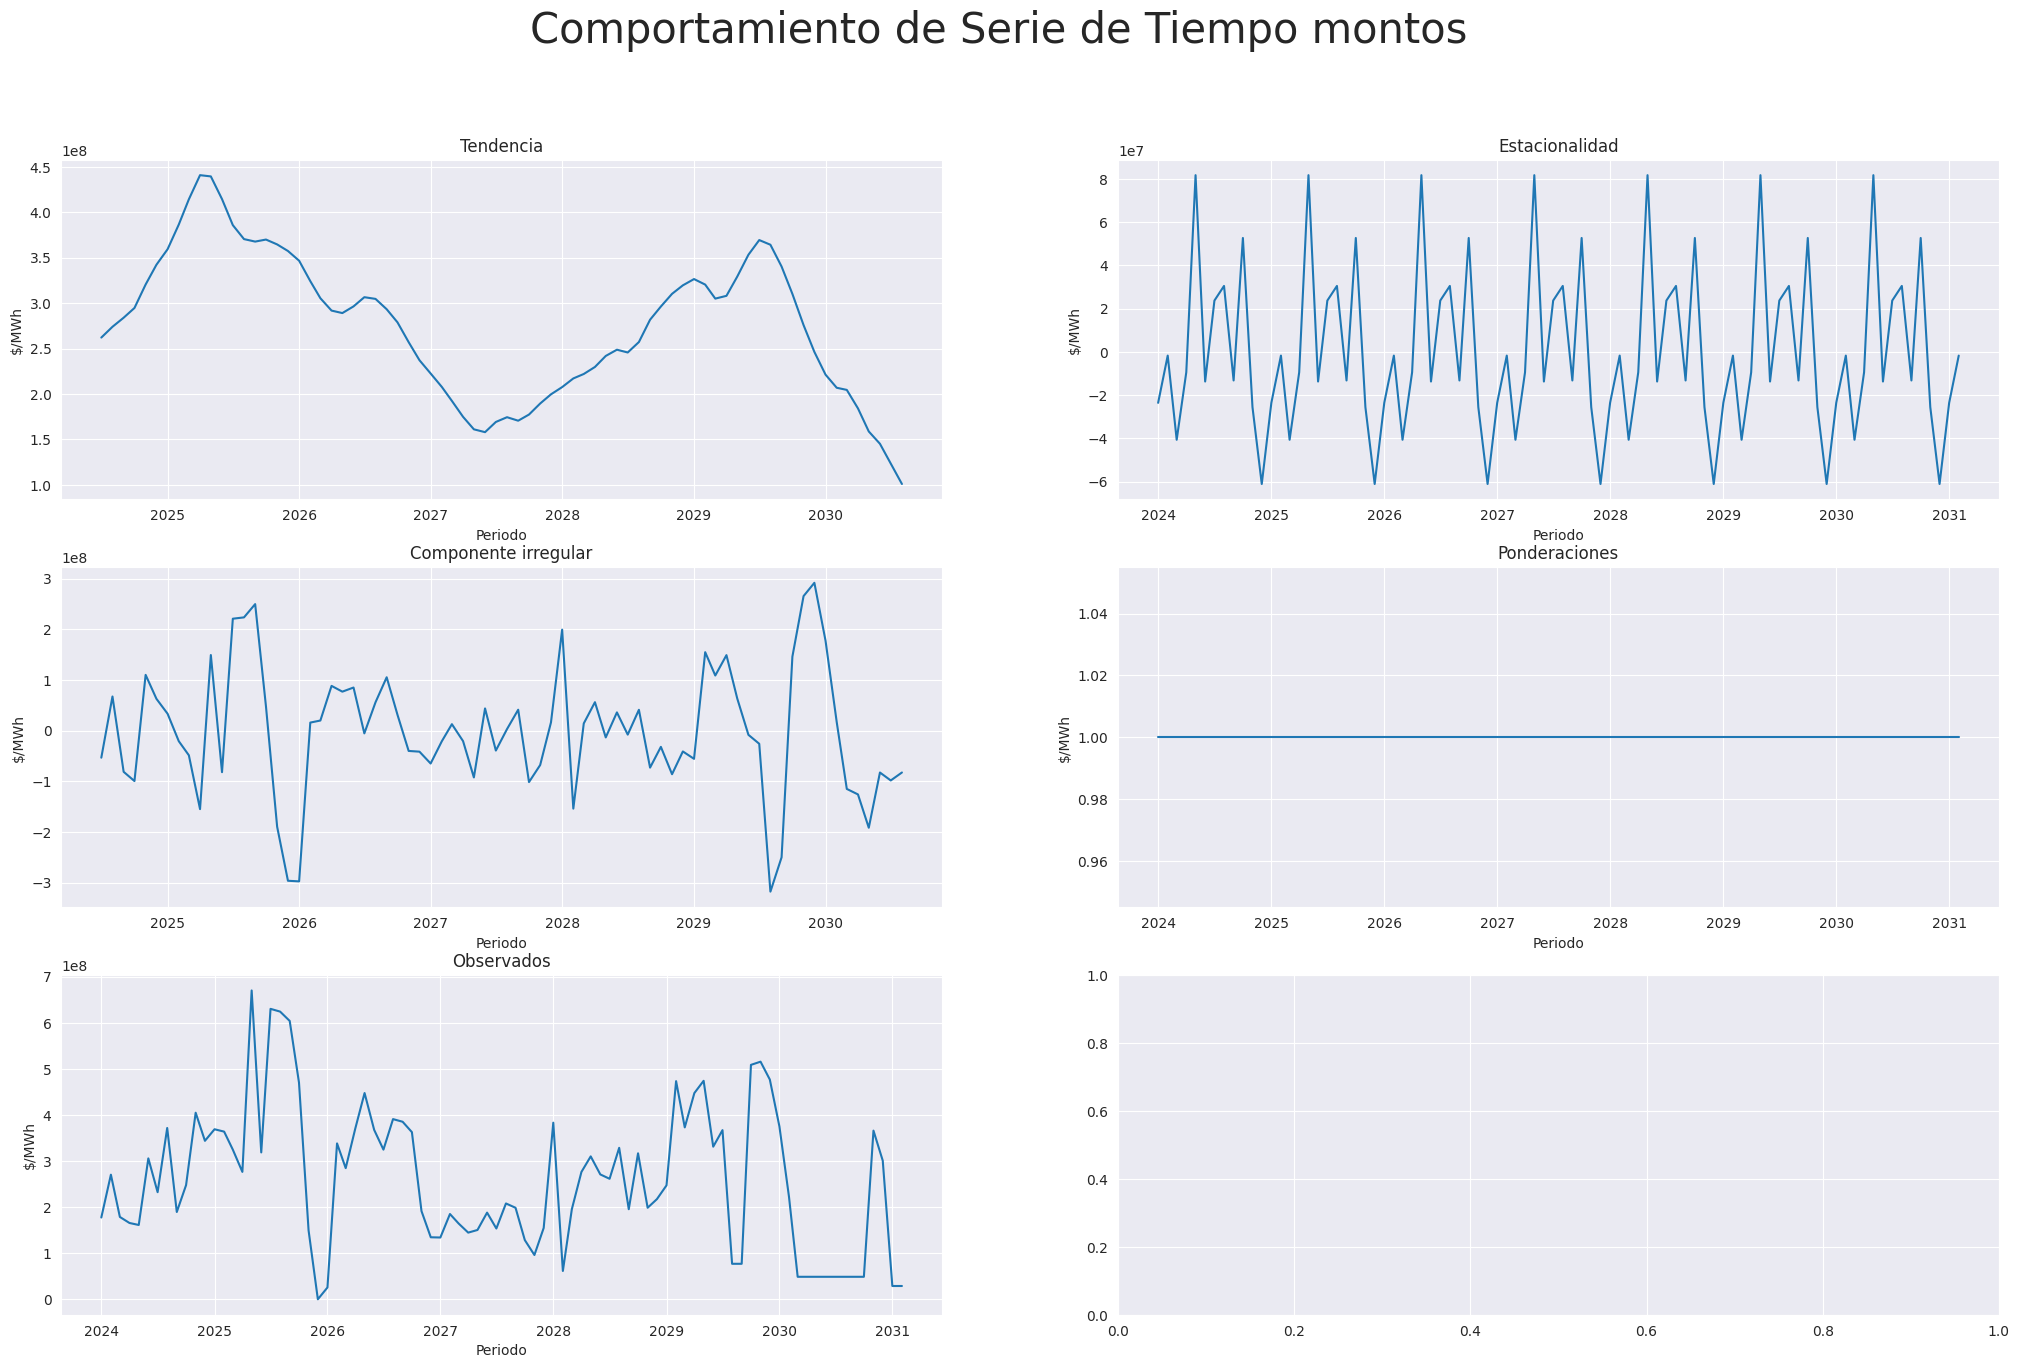

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(25, 15))
fig.suptitle('Comportamiento de Serie de Tiempo montos', fontsize=30)

axs[0,0].plot(decompose_monto_input.trend, label= 'Tendencia')
axs[0,0].set_title('Tendencia')
axs[0,0].set_ylabel('$/MWh')
axs[0,0].set_xlabel('Periodo')

axs[0,1].plot(decompose_monto_input.seasonal, label='Estacionalidad')
axs[0,1].set_title('Estacionalidad')
axs[0,1].set_ylabel('$/MWh')
axs[0,1].set_xlabel('Periodo')


axs[1,0].plot(decompose_monto_input.resid, label='Irregular')
axs[1,0].set_title('Componente irregular')
axs[1,0].set_ylabel('$/MWh')
axs[1,0].set_xlabel('Periodo')

axs[1,1].plot(decompose_monto_input.weights, label='Ponderaciones')
axs[1,1].set_title('Ponderaciones')
axs[1,1].set_ylabel('$/MWh')
axs[1,1].set_xlabel('Periodo')

axs[2,0].plot(decompose_monto_input.observed, label='Observados')
axs[2,0].set_title('Observados')
axs[2,0].set_ylabel('$/MWh')
axs[2,0].set_xlabel('Periodo')

In [ ]:
count_null = df_lp.isnull().sum()
total = df_lp.isnull().count()
percent = count_null / total


df_null = pd.concat([count_null, percent], axis= 1, keys= ['count_null', 'percent']).T

df_null

,seasonal,trend,resid,dummy_monto
count_null,0.0,12.000000,12.000000,0.0
percent,0.0,0.139535,0.139535,0.0


In [ ]:
df_lp['trend'].fillna(df_lp['trend'].median(), inplace = True)
df_lp['resid'].fillna(df_lp['resid'].median(), inplace = True)


df_lp

,seasonal,trend,resid,dummy_monto
fecha_lp,,,,
2024-01-01,-2.353579e+07,2.864877e+08,-6.723681e+06,0
2024-02-01,-1.695084e+06,2.864877e+08,-6.723681e+06,0
2024-03-01,-4.060600e+07,2.864877e+08,-6.723681e+06,0
2024-04-01,-9.410204e+06,2.864877e+08,-6.723681e+06,0
2024-05-01,8.172681e+07,2.864877e+08,-6.723681e+06,0
...,...,...,...,...
2030-10-01,5.268846e+07,2.864877e+08,-6.723681e+06,0
2030-11-01,-2.551070e+07,2.864877e+08,-6.723681e+06,0
2030-12-01,-6.105116e+07,2.864877e+08,-6.723681e+06,0


In [ ]:
a = [1,2,3]
b = [4]

c = a + b

print(c)

[1, 2, 3, 4]


In [ ]:
df_lp

,seasonal,trend,resid,dummy_monto
fecha_lp,,,,
2024-01-01,-2.353579e+07,2.864877e+08,-6.723681e+06,0
2024-02-01,-1.695084e+06,2.864877e+08,-6.723681e+06,0
2024-03-01,-4.060600e+07,2.864877e+08,-6.723681e+06,0
2024-04-01,-9.410204e+06,2.864877e+08,-6.723681e+06,0
2024-05-01,8.172681e+07,2.864877e+08,-6.723681e+06,0
...,...,...,...,...
2030-10-01,5.268846e+07,2.864877e+08,-6.723681e+06,0
2030-11-01,-2.551070e+07,2.864877e+08,-6.723681e+06,0
2030-12-01,-6.105116e+07,2.864877e+08,-6.723681e+06,0


In [ ]:
X_lp = df_lp[columns_predict]

X_lp = sm.add_constant(X_lp)

In [ ]:
y_pred_lp = results.predict(X_lp).sort_index(ascending=True)

Text(0, 0.5, '$')

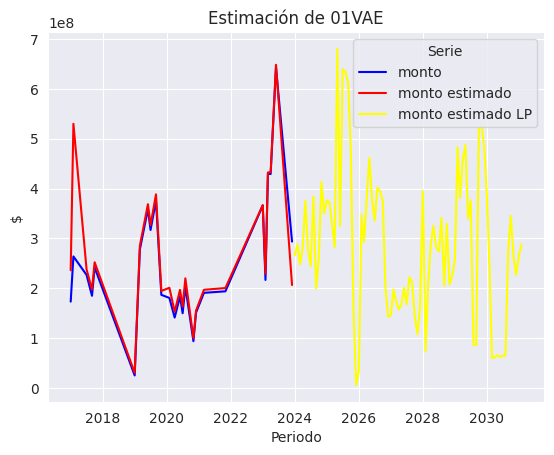

In [ ]:

#plt.plot(y, label='monto', color='green')
plt.plot(y_test, label='monto', color='blue')
plt.plot(y_pred, label= 'monto estimado', color='red')
plt.plot(y_pred_lp, label= 'monto estimado LP', color='yellow')

#add legend
plt.legend(title='Serie')
plt.title(f'Estimación de {central}')
plt.xlabel(f'Periodo')
plt.ylabel(f'$')

In [ ]:
print(y_test)
print(y_pred)
print(y_pred_lp)

fecha
2017-01-01    1.731094e+08
2017-02-01    2.638124e+08
2017-07-01    2.267121e+08
2017-09-01    1.847824e+08
2017-10-01    2.417295e+08
2019-01-01    2.499717e+07
2019-03-01    2.776670e+08
2019-06-01    3.586956e+08
2019-07-01    3.168407e+08
2019-09-01    3.758595e+08
2019-11-01    1.867077e+08
2020-02-01    1.805096e+08
2020-04-01    1.411266e+08
2020-06-01    1.834700e+08
2020-07-01    1.498413e+08
2020-08-01    2.028803e+08
2020-11-01    9.372867e+07
2020-12-01    1.510163e+08
2021-03-01    1.907382e+08
2021-11-01    1.937745e+08
2023-01-01    3.658929e+08
2023-02-01    2.166207e+08
2023-03-01    4.294851e+08
2023-04-01    4.291031e+08
2023-06-01    6.428430e+08
2023-12-01    2.935613e+08
Name: MONTO_NETO, dtype: float64
fecha
2017-01-01    2.360567e+08
2017-02-01    5.298302e+08
2017-07-01    2.376717e+08
2017-09-01    1.974913e+08
2017-10-01    2.520712e+08
2019-01-01    3.009201e+07
2019-03-01    2.851101e+08
2019-06-01    3.685218e+08
2019-07-01    3.266973e+08
2019-09-01